# Emotionally Intelligent GPT

This project will look to use 2 models to create an emotionally intelligent response to a prompt

In [1]:
import torch
import huggingface
from datasets import load_dataset
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
import random
import pandas as pd
from transformers import DistilBertForSequenceClassification,  AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer
import numpy as np
import evaluate
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay





c:\Users\tom_r\anaconda3\envs\Generative_AI\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Text Emotion Classifier

##### Dataset: dair-ai/ emotion on hugging face 

Emotion is a dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise. For more detailed information please refer to the paper

The data fields are:

text: a string feature.
label: a classification label, with possible values including sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5).

In [2]:
# Load dataset

dataset = load_dataset('dair-ai/emotion')

# check dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [3]:
# map to a human readable label
label_map = {
    0 : 'sadness',
    1 : 'joy',
    2 : 'love',
    3 : 'anger',
    4 : 'fear',
    5 : 'suprise'
 
}

In [4]:
df = pd.DataFrame()
df['train_text'] = dataset['train']['text']
df['train_label_index'] = dataset['train']['label']
df['train_label'] = df['train_label_index'].map(label_map)


In [5]:
df.head(10)

,train_text,train_label_index,train_label
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
5,ive been feeling a little burdened lately wasn...,0,sadness
6,ive been taking or milligrams or times recomme...,5,suprise
7,i feel as confused about life as a teenager or...,4,fear
8,i have been with petronas for years i feel tha...,1,joy
9,i feel romantic too,2,love


In [6]:
df['train_label'].value_counts()

train_label
joy        5362
sadness    4666
anger      2159
fear       1937
love       1304
suprise     572
Name: count, dtype: int64

In [7]:
# load emotion classification model 

device = "cuda"

checkpoint = "bert-base-uncased"
classifier = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=6)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tom_r\anaconda3\envs\Generative_AI\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
def preprocess_function(messages):
    '''Function to tokenize all of the articles and labels in the dataset in advance'''
    inputs = [example for example in messages["text"]]
    
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding=True)

    model_inputs["label"] = messages["label"]
    return model_inputs


In [9]:
# test preprocess function is tokenizing correctly
original_message = dataset['train'][:3]['text']

tokenized_example = preprocess_function(dataset['train'][:3])

detokenized_examples = [tokenizer.decode(input_ids, skip_special_tokens=True) for input_ids in tokenized_example['input_ids']]

print(tokenized_example)
print(150 * "-", "\n Original article:\n")
print(original_message)
print("\n\n", 150 * "-", "\n Detokenized article:\n")
print(detokenized_examples)

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'label': [0, 0, 3]}
------------------------------------------------------------------------------------------------------------------------------------------------------ 
 Origin

In [10]:
def preprocess_function(messages):
    '''Function to tokenize all of the messages in the dataset in advance'''
    inputs = messages['text']
    
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding=True)

    model_inputs["label"] = messages["label"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function)

In [11]:
print(tokenized_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})


In [12]:
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
#tokenized_dataset['train']['labels']

In [13]:
import logging

logging.basicConfig(filename="training_logs.txt", level=logging.INFO)

In [14]:
output_dir = f'./article-highlight-training-{str(int(time.time()))}'

# Padding for batch of data that will be fed into model for training
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    "test-trainer",
    num_train_epochs=3,
    evaluation_strategy="epoch",
    weight_decay=5e-4,
    learning_rate=5e-6,  # Lower learning rate
    save_strategy="epoch",
    report_to="none",
    per_device_train_batch_size=16,
    max_grad_norm=1.0  
)


# Metric for validation error
def compute_metrics(eval_preds):
    metric_accuracy = evaluate.load("accuracy")
    metric_f1 = evaluate.load("f1")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate both accuracy and macro F1 (for multiclass)
    accuracy = metric_accuracy.compute(predictions=predictions, references=labels)
    f1 = metric_f1.compute(predictions=predictions, references=labels, average='macro')
    
    return {**accuracy, **f1}

# Define trainer
trainer = Trainer(
    classifier,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)



c:\Users\tom_r\anaconda3\envs\Generative_AI\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:

trainer.train()

  0%|          | 0/3000 [00:00<?, ?it/s]c:\Users\tom_r\anaconda3\envs\Generative_AI\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
 17%|█▋        | 501/3000 [01:26<07:40,  5.43it/s]

{'loss': 1.3377, 'grad_norm': 13.175256729125977, 'learning_rate': 4.166666666666667e-06, 'epoch': 0.5}


 33%|███▎      | 1000/3000 [02:52<06:13,  5.36it/s]

{'loss': 0.7874, 'grad_norm': 10.853013038635254, 'learning_rate': 3.3333333333333333e-06, 'epoch': 1.0}


                                                   
 33%|███▎      | 1000/3000 [02:59<06:13,  5.36it/s]

{'eval_loss': 0.5320850610733032, 'eval_accuracy': 0.8315, 'eval_f1': 0.7070808181911635, 'eval_runtime': 7.3136, 'eval_samples_per_second': 273.465, 'eval_steps_per_second': 34.183, 'epoch': 1.0}


 50%|█████     | 1501/3000 [04:32<04:11,  5.97it/s]  

{'loss': 0.4299, 'grad_norm': 2.3128416538238525, 'learning_rate': 2.5e-06, 'epoch': 1.5}


 67%|██████▋   | 2000/3000 [05:58<02:49,  5.89it/s]

{'loss': 0.3247, 'grad_norm': 14.27590560913086, 'learning_rate': 1.6666666666666667e-06, 'epoch': 2.0}


                                                   
 67%|██████▋   | 2000/3000 [06:05<02:49,  5.89it/s]

{'eval_loss': 0.26499804854393005, 'eval_accuracy': 0.9155, 'eval_f1': 0.8865989664603807, 'eval_runtime': 7.2324, 'eval_samples_per_second': 276.535, 'eval_steps_per_second': 34.567, 'epoch': 2.0}


 83%|████████▎ | 2501/3000 [07:37<01:22,  6.04it/s]

{'loss': 0.2408, 'grad_norm': 6.091405868530273, 'learning_rate': 8.333333333333333e-07, 'epoch': 2.5}


100%|██████████| 3000/3000 [09:04<00:00,  5.79it/s]

{'loss': 0.2265, 'grad_norm': 2.752739906311035, 'learning_rate': 0.0, 'epoch': 3.0}


                                                   
100%|██████████| 3000/3000 [09:14<00:00,  5.79it/s]

{'eval_loss': 0.23772408068180084, 'eval_accuracy': 0.9185, 'eval_f1': 0.8915839556029949, 'eval_runtime': 7.1458, 'eval_samples_per_second': 279.886, 'eval_steps_per_second': 34.986, 'epoch': 3.0}


100%|██████████| 3000/3000 [09:17<00:00,  5.38it/s]

{'train_runtime': 557.8349, 'train_samples_per_second': 86.047, 'train_steps_per_second': 5.378, 'train_loss': 0.5578190409342448, 'epoch': 3.0}


TrainOutput(global_step=3000, training_loss=0.5578190409342448, metrics={'train_runtime': 557.8349, 'train_samples_per_second': 86.047, 'train_steps_per_second': 5.378, 'total_flos': 1161463243423104.0, 'train_loss': 0.5578190409342448, 'epoch': 3.0})

In [16]:

# Testing the finetuned model on the test set
predictions_output = trainer.predict(tokenized_dataset["test"])
y_pred = np.argmax(predictions_output.predictions, axis=-1)

# get the true labels
y_true = tokenized_dataset["test"]["labels"]
y_true = np.array(y_true)


print(classification_report(y_true, y_pred, digits=3))


100%|██████████| 250/250 [00:06<00:00, 35.75it/s]

              precision    recall  f1-score   support

           0      0.957     0.948     0.952       581
           1      0.947     0.934     0.941       695
           2      0.798     0.868     0.831       159
           3      0.901     0.931     0.916       275
           4      0.901     0.853     0.876       224
           5      0.714     0.758     0.735        66

    accuracy                          0.917      2000
   macro avg      0.870     0.882     0.875      2000
weighted avg      0.919     0.917     0.918      2000



In [17]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[551,   8,   1,  13,   8,   0],
       [  6, 649,  33,   4,   2,   1],
       [  1,  19, 138,   1,   0,   0],
       [ 10,   3,   1, 256,   5,   0],
       [  7,   0,   0,   7, 191,  19],
       [  1,   6,   0,   3,   6,  50]])

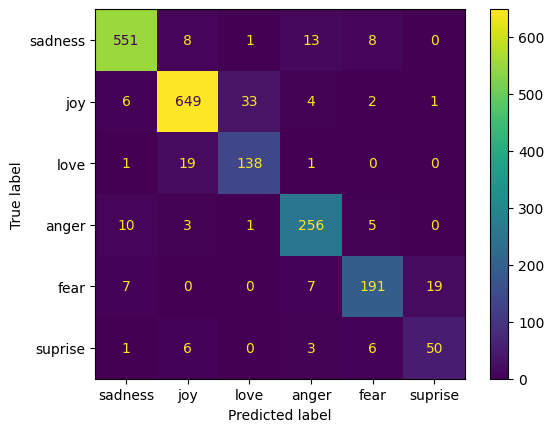

In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[label_map[i] for i in sorted(label_map.keys())])  
disp.plot()

plt.show()

In [19]:
def test_sentence(sentence):
    
    inputs = tokenizer(sentence, return_tensors = 'pt', padding=True, truncation = True)

    # move inputs to the same device
    inputs = {key : value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = classifier(**inputs)

    # convert logits to label index
    predicted_label_id = torch.argmax(outputs.logits, dim = -1).item()

    predicted_label = label_map[predicted_label_id]

    print('Sentence: ', sentence)
    print("Predicted emotion: ", predicted_label)

In [20]:
example_sentences = ['AAAARGH THIS IS SO ANNOYING', 'I am really enjoying being outdoors', 'My cat just died!', 'Oh my! A spider!', 'I miss the city really badly', 'Wow!', 'You made me jump!']

for sentence in example_sentences:
    test_sentence(sentence)

Sentence:  AAAARGH THIS IS SO ANNOYING
Predicted emotion:  anger
Sentence:  I am really enjoying being outdoors
Predicted emotion:  joy
Sentence:  My cat just died!
Predicted emotion:  anger
Sentence:  Oh my! A spider!
Predicted emotion:  suprise
Sentence:  I miss the city really badly
Predicted emotion:  sadness
Sentence:  Wow!
Predicted emotion:  joy
Sentence:  You made me jump!
Predicted emotion:  joy
